<a href="https://colab.research.google.com/github/whiteribbonalliance/womenshealthandwellbeing_public/blob/main/multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 22.7 MB/s eta

**Data preparation**

In [ ]:
import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Load the data from the Excel file
data = pd.read_excel("/content/cleaned_labeled_data.xlsx")


In [ ]:
data['text'] = data['text'].str.lower()

In [ ]:
data.columns

Index(['Unnamed: 0', 'text', 'demands'], dtype='object')

In [ ]:
data.shape

(7914, 3)

In [ ]:
### check distribution of onme demands vs more demands

import ast

# Convert the string representation of lists to actual lists
data['demands_list'] = data['demands'].apply(ast.literal_eval)

# Calculate the number of demands for each row
data['num_demands'] = data['demands_list'].apply(len)

# Count rows with more than one demand and rows with only one demand
more_than_one_demand = (data['num_demands'] > 1).sum()
only_one_demand = (data['num_demands'] == 1).sum()

more_than_one_demand, only_one_demand


(1936, 5978)

In [ ]:
# Flatten the lists in the 'demands_list' column to get individual demands
all_demands = [demand for sublist in data['demands_list'] for demand in sublist]

# Count the occurrences of each demand
demand_distribution = pd.Series(all_demands).value_counts()

demand_distribution


In [ ]:

# # Drop the unnecessary unnamed index column
# data.drop(columns=['Unnamed: 0'], inplace=True)

def transform_complete_data(df):
    """Transforms the entire data."""
    # Convert the string representation of list to actual list
    df['demands'] = df['demands'].apply(ast.literal_eval)

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    # Fit and transform the 'demands' column to get the binary matrix
    binary_matrix = mlb.fit_transform(df['demands'])

    # Convert the binary matrix to a DataFrame
    binary_df = pd.DataFrame(binary_matrix, columns=mlb.classes_)

    # Concatenate the original data with the binary DataFrame
    prepared_df = pd.concat([df['text'], binary_df], axis=1)

    return prepared_df, mlb

# Transform the entire data
prepared_data, mlb = transform_complete_data(data)

# Split the transformed data into training and test sets (80-20)
train_prepared, test_prepared = train_test_split(prepared_data, test_size=0.15, random_state=42)

print(train_prepared.head())
print(test_prepared.head())

In [ ]:
len(mlb.classes_)

23

**Train the model**

In [ ]:
from simpletransformers.classification import ClassificationModel, MultiLabelClassificationModel

# Define the model
model = MultiLabelClassificationModel('bert', 'bert-base-uncased', num_labels=len(mlb.classes_), args={'overwrite_output_dir': True, 'num_train_epochs': 15})

# Split the training data into features and labels
train_data_text = train_prepared['text'].tolist()
train_labels = train_prepared[mlb.classes_].values.tolist()

# Train the model
model.train_model(pd.DataFrame({'text': train_data_text, 'labels': train_labels}))


Some weights of BertForMultiLabelSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6726 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 0 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 1 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/841 [00:00<?, ?it/s]

(12615, 0.043616298867211085)

**Evaluate the model**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

test_prepared.dropna(subset=['text'], inplace=True)

# Split the test data into features and labels
test_data_text = test_prepared['text'].tolist()



test_labels = test_prepared[mlb.classes_].values

# Get predictions for the test set
predictions, raw_outputs = model.predict(test_data_text)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)

# Generate a classification report
report = classification_report(test_labels, predictions, target_names=mlb.classes_)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)


  0%|          | 0/1188 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Accuracy: 0.67003367003367

Classification Report:
                                                         precision    recall  f1-score   support

                   Autonomy, Equality, and Empowerment       0.71      0.71      0.71        59
                                                Cancer       1.00      0.91      0.95        58
                                 Communicable Diseases       0.87      0.72      0.79        36
                       Education and Vocational Skills       0.84      0.87      0.85       113
                           Food and Adequate Nutrition       0.89      0.98      0.93        82
                Free, Affordable or Insured Healthcare       0.77      0.81      0.79        94
  Fully-functional and well-equipped Health Facilities       0.81      0.76      0.78       127
                                        Health Workers       0.67      0.67      0.67        63
High Quality, Inclusive and Respectful Health Services       0.58      0.61      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
index_to_label = {i: label for i, label in enumerate(mlb.classes_)}
index_to_label

{0: 'Autonomy, Equality, and Empowerment',
 1: 'Cancer',
 2: 'Communicable Diseases',
 3: 'Education and Vocational Skills',
 4: 'Food and Adequate Nutrition',
 5: 'Free, Affordable or Insured Healthcare',
 6: 'Fully-functional and well-equipped Health Facilities',
 7: 'Health Workers',
 8: 'High Quality, Inclusive and Respectful Health Services',
 9: 'Interpersonal Relationships and Social Support',
 10: 'Maternal, Newborn, Child Health',
 11: 'Menstrual & Menopausal Cycles',
 12: 'Mental Health',
 13: 'No Harmful Practices and GBV',
 14: 'Non-Communicable Diseases',
 15: 'Physical Activity and Rest',
 16: 'Policy and Social Welfare',
 17: 'Safety',
 18: 'Sexual and Reproductive Health',
 19: 'Sustainable Energy & Agriculture',
 20: 'Transportation and Road Safety',
 21: 'Water, Sanitation & Hygiene',
 22: 'Work & Financial Support'}

  0%|          | 0/1188 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

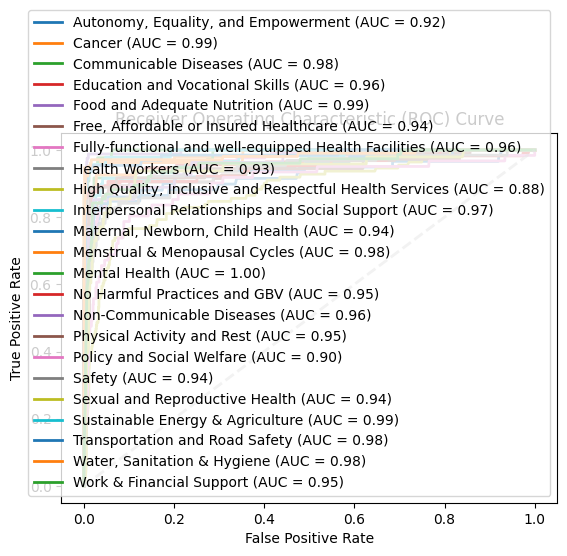

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from simpletransformers.classification import MultiLabelClassificationModel

# Load the trained model
#model = MultiLabelClassificationModel('model_type', 'path_to_saved_model_directory')

# Extract the text data from the dataframe for prediction
texts = test_prepared['text'].tolist()

# Use the model to predict
predictions, raw_outputs = model.predict(texts)

# List to store AUC values for each category
all_aucs = {}

# Iterate over each category
for cat_no, label in index_to_label.items():

    # Get ground truths from the dataframe (one-hot encoded structure)
    all_gts = test_prepared[label].values

    # Get predicted probabilities from raw_outputs for the current category
    all_probas = raw_outputs[:, cat_no]

    # Calculate ROC curve values
    fpr, tpr, _ = roc_curve(all_gts, all_probas)

    # Calculate AUC
    this_auc = auc(fpr, tpr)
    all_aucs[label] = this_auc

    # Plot ROC curve for the current category
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {this_auc:.2f})")

# Plot reference line
plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=2, linestyle="--")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()


In [ ]:
all_aucs

{'Autonomy, Equality, and Empowerment': 0.9182642506492922,
 'Cancer': 0.9886328959414098,
 'Communicable Diseases': 0.9756703317901234,
 'Education and Vocational Skills': 0.9585511422103312,
 'Food and Adequate Nutrition': 0.9949719931195695,
 'Free, Affordable or Insured Healthcare': 0.9395688280368742,
 'Fully-functional and well-equipped Health Facilities': 0.9611828092647703,
 'Health Workers': 0.9342857142857143,
 'High Quality, Inclusive and Respectful Health Services': 0.8804779710072189,
 'Interpersonal Relationships and Social Support': 0.9671375598624852,
 'Maternal, Newborn, Child Health': 0.9390070298769772,
 'Menstrual & Menopausal Cycles': 0.9818004912750822,
 'Mental Health': 0.9963440641819844,
 'No Harmful Practices and GBV': 0.9513178380782917,
 'Non-Communicable Diseases': 0.9575238459820716,
 'Physical Activity and Rest': 0.9479046103395061,
 'Policy and Social Welfare': 0.896337294718315,
 'Safety': 0.9403428047153024,
 'Sexual and Reproductive Health': 0.9419499

{'Autonomy, Equality, and Empowerment': 0.9182642506492922,
 'Cancer': 0.9886328959414098,
 'Communicable Diseases': 0.9756703317901234,
 'Education and Vocational Skills': 0.9585511422103312,
 'Food and Adequate Nutrition': 0.9949719931195695,
 'Free, Affordable or Insured Healthcare': 0.9395688280368742,
 'Fully-functional and well-equipped Health Facilities': 0.9611828092647703,
 'Health Workers': 0.9342857142857143,
 'High Quality, Inclusive and Respectful Health Services': 0.8804779710072189,
 'Interpersonal Relationships and Social Support': 0.9671375598624852,
 'Maternal, Newborn, Child Health': 0.9390070298769772,
 'Menstrual & Menopausal Cycles': 0.9818004912750822,
 'Mental Health': 0.9963440641819844,
 'No Harmful Practices and GBV': 0.9513178380782917,
 'Non-Communicable Diseases': 0.9575238459820716,
 'Physical Activity and Rest': 0.9479046103395061,
 'Policy and Social Welfare': 0.896337294718315,
 'Safety': 0.9403428047153024,
 'Sexual and Reproductive Health': 0.9419499

##Inference code

In [ ]:
from simpletransformers.classification import ClassificationModel, MultiLabelClassificationModel
from scipy.special import softmax
from sklearn.preprocessing import LabelBinarizer

# Specify the path to your saved model
saved_model_dir = r"/content/drive/MyDrive/Thomas/sub_category_24/model_09_10"  # replace with your actual path

# Load the model from the checkpoint
model = MultiLabelClassificationModel("bert", saved_model_dir, use_cuda=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
index_to_label= {0: 'Autonomy, Equality, and Empowerment',
 1: 'Cancer',
 2: 'Communicable Diseases',
 3: 'Education and Vocational Skills',
 4: 'Food and Adequate Nutrition',
 5: 'Free, Affordable or Insured Healthcare',
 6: 'Fully-functional and well-equipped Health Facilities',
 7: 'Health Workers',
 8: 'High Quality, Inclusive and Respectful Health Services',
 9: 'Interpersonal Relationships and Social Support',
 10: 'Maternal, Newborn, Child Health',
 11: 'Menstrual & Menopausal Cycles',
 12: 'Mental Health',
 13: 'No Harmful Practices and GBV',
 14: 'Non-Communicable Diseases',
 15: 'Physical Activity and Rest',
 16: 'Policy and Social Welfare',
 17: 'Safety',
 18: 'Sexual and Reproductive Health',
 19: 'Sustainable Energy & Agriculture',
 20: 'Transportation and Road Safety',
 21: 'Water, Sanitation & Hygiene',
 22: 'Work & Financial Support'}

In [ ]:
# Create a dictionary mapping from index to class name
#index_to_label = {i: label for i, label in enumerate(mlb.classes_)}

def labels_from_predictions(predictions):
    """Convert predictions to label names using the index_to_label dictionary."""
    return [[index_to_label[idx] for idx, val in enumerate(row) if val == 1] for row in predictions]

def predict_single(text):
    """Predict the labels for a single text input."""
    predictions, _ = model.predict([text])
    return labels_from_predictions(predictions)[0]

def predict_batch(texts):
    """Predict the labels for a batch of text inputs."""
    predictions, _ = model.predict(texts)
    return labels_from_predictions(predictions)

# def predict_dataframe(df):
#     """Predict the labels for an entire dataframe and add them to a new 'demands' column."""
#     texts = df['text'].tolist()
#     predictions, _ = model.predict(texts)
#     df['demands'] = labels_from_predictions(predictions)
#     return df

def predict_dataframe(df):
    """Predict the labels for an entire dataframe and add them to a new 'demands' column."""
    texts = df['text_lower'].tolist()
    predictions, _ = model.predict(texts)
    df['demands'] = labels_from_predictions(predictions)
    return df

# Example usage:
single_text = "how to fight seasonal fever"
print(predict_single(single_text))


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

['Communicable Diseases']


In [ ]:
import pandas as pd
df_infer= pd.read_csv(r'/content/missing_translated.csv')

In [ ]:
df_infer['text_lower'] = df_infer['text'].str.lower()

In [ ]:
df= predict_dataframe(df_infer)

  0%|          | 0/4335 [00:00<?, ?it/s]

  0%|          | 0/542 [00:00<?, ?it/s]